# Segmentation Model

This is copied and modified from the example. I changed the colors of the masks for our data and changed the picture size. Someone should go through this and determine what is happening, and what to keep. There are spelling errors throughout the text, which could be fixed. Trying new models is relatively easy -- there are very few places to change. Most of the code here is for augmentation, visualization, and loading data into the model. The actual model structures are in the segmentation_models_pytorch library, and choice of model is easy to choose and change.

# Initialization

In [1]:
# libraries
# the list should be updated based on what is needed
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torch.optim import lr_scheduler

import torch
import random 
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils
import albumentations as albu

#import torch_directml
import os
#import pytorch_lightning as pl      # This is used in a different example

In [2]:
# this part of the code is to seed the rng, to give consistent results for demostration
# likely, this can be removed
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
# files

DATSET_NAME = "Dataset"

X_TRAIN_DIR = f"{DATSET_NAME}/Train/JPG"
Y_TRAIN_DIR = f"{DATSET_NAME}/Train/PNG"

X_VALID_DIR = f"{DATSET_NAME}/Valid/JPG"
Y_VALID_DIR = f"{DATSET_NAME}/Valid/PNG"

X_TEST_DIR = f"{DATSET_NAME}/Valid/JPG"
Y_TEST_DIR = f"{DATSET_NAME}/Valid/PNG"

MODEL_SAVE_DIR = "models"
MODEL_SAVE_NAME = "best_model_new"

In [ ]:
# parameters
# I need to copy this lower for additional models

CLASSES = [
    "background",
    "road"
]

# https://segmentation-models-pytorch.readthedocs.io/en/latest/encoders.html
ENCODER = 'resnet18'
# based on encoder, typically imagenet
# efficientnet-b4, mobilenet_v2, dpn68, vgg16, xception, densenet169, se_resnet50
ENCODER_WEIGHTS = 'imagenet'
# “sigmoid”, “softmax”, “logsoftmax”, “tanh”, “identity”, callable and None
ACTIVATION = 'softmax2d' 
# directml
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#DEVICE = torch_directml.device()

MODEL_NAME = 'Unet'

EPOCHS = 40
BATCH_SIZE = 32

INIT_LR = 0.0005
LR_DECREASE_STEP = 15
LR_DECREASE_COEF = 2 # LR будет разделен на этот коэф раз в LR_DECREASE_STEP эпох

# This retains the ratio close to the given image size, but should prevent the massive time consumption of the full size
# 448 = 32 * 14
INFER_WIDTH = 448    #960
INFER_HEIGHT = 256   #544

# https://segmentation-models-pytorch.readthedocs.io/en/latest/losses.html
loss = utils.losses.DiceLoss()

# Visualization

In [ ]:
# Both of these are for visualization

def _convert_multichannel2singlechannel(mc_mask: np.ndarray):
    """ Осуществляет перевод трехканальной маски (число каналов сколько классов) в трехканальное 
    изображение где будет расцветка как зададим в словаре colors_imshow для классов """

    colors_imshow = {
            "background" : np.array([0, 0, 0]),
            "road" : np.array([255, 255, 255]),
    }

    # h * w * 3 colors
    sc_mask = np.zeros((mc_mask[0].shape[0], mc_mask[0].shape[1], 3), dtype=np.uint8)
    square_ratios = {}

    for i, singlechannel_mask in enumerate(mc_mask):

        cls = CLASSES[i]
        singlechannel_mask = singlechannel_mask.squeeze()

        # Заодно осуществляет подсчет процента каждого класса (сумма пикселей на общее число)
        square_ratios[cls] = singlechannel_mask.sum() / singlechannel_mask.size
        
        sc_mask += np.multiply.outer(singlechannel_mask > 0, colors_imshow[cls]).astype(np.uint8)
        

    title = "Площади: " + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    return sc_mask, title


def visualize_multichannel_mask(img: np.ndarray, multichannel_mask: np.ndarray):
    """ Реализация демонстрации маски и самого изображения """
    # размер маски: H, W, CHANNEL
    _, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(img)
    multichannel_mask = multichannel_mask.transpose(2, 0, 1)
    mask_to_show, title = _convert_multichannel2singlechannel(multichannel_mask)
    axes[1].imshow(mask_to_show)
    axes[1].set_title(title)

    plt.tight_layout()
    plt.show()

In [6]:
class Dataset(BaseDataset):
    def __init__(
        self,
        images_dir,
        masks_dir,
        augmentation=None,
        preprocessing=None
    ):
        self.images_paths = glob(f"{images_dir}/*")
        self.masks_paths = glob(f"{masks_dir}/*")

        # our colors are no longer in a file
        self.cls_colors = self._get_classes_colors()#LABEL_COLORS_FILE)

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    # remove the references to a file
    def _get_classes_colors(self): #, label_colors_dir):
        #cls_colors = {}
        #with open(label_colors_dir) as file:
        #    while line := file.readline():
        #        R, G, B, label = line.rstrip().split()
        #        cls_colors[label] = np.array([B, G, R], dtype=np.uint8)

        keyorder = CLASSES
        cls_colors_ordered = {}
        for k in keyorder:
            if k=="road":
                cls_colors_ordered[k] = np.array([255, 255, 255], dtype=np.uint8)
            elif k=="background":
                cls_colors_ordered[k] = np.array([0, 0, 0], dtype=np.uint8)
            else:
                raise ValueError(f"unexpected label {k}")

        return cls_colors_ordered

    def __getitem__(self, i):
        image = cv2.imread(self.images_paths[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_paths[i])
        masks = [cv2.inRange(mask, color, color) for color in self.cls_colors.values()]
        masks = [(m > 0).astype("float32") for m in masks]
        mask = np.stack(masks, axis=-1).astype("float")

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample["image"], sample["mask"]

        return image, mask

    def __len__(self):
        return len(self.images_paths)

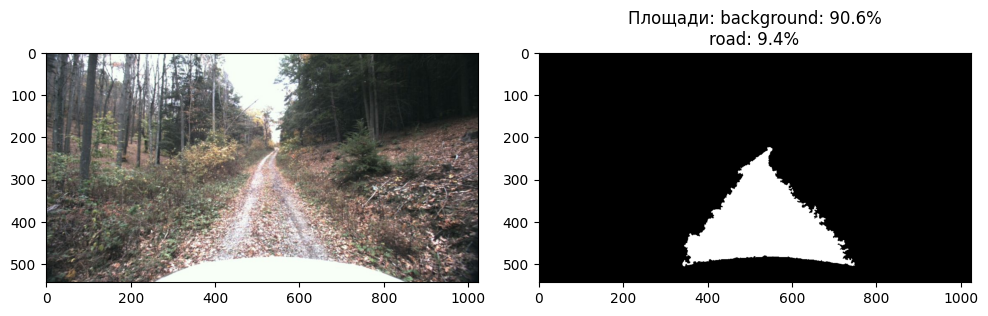

In [ ]:
# Just an example, to show it works
dataset = Dataset(X_TRAIN_DIR, Y_TRAIN_DIR)
image, mask = dataset[np.random.randint(len(dataset))]
visualize_multichannel_mask(image, mask)

# Augmentation

In [ ]:
# note that always_apply -> p=1.0 as always_apply no longer exists
# always_apply options are sizing the image to the correct size, while other transforms are 50%

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.LongestMaxSize(max_size=INFER_HEIGHT, p=1.0),
        albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=2, p=1.0),
        albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH, p=1.0),

        albu.OneOf(
            [
                albu.Sharpen(alpha=(0.1, 0.2), lightness=(0.1, 0.2), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.Blur(blur_limit=[1, 3], p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.GaussNoise(var_limit=(1, 5), p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=5, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
                albu.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10, p=0.5),  # Уменьшение вероятности и уменьшение интенсивности
            ],
            p=0.7,  # Уменьшение вероятности применения любой аугментации цвета
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, p=1.0),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=2, p=1.0),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, p=1.0)]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    # Осуществит стартовую нормализацию данных согласно своим значениям или готовым для imagenet
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

C:\Users\QuanumWarrior\AppData\Local\Temp\ipykernel_12496\3191627627.py:6: UserWarning: Argument(s) 'always_apply' are not valid for transform MaxSizeTransform
  albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
C:\Users\QuanumWarrior\AppData\Local\Temp\ipykernel_12496\3191627627.py:7: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  albu.PadIfNeeded(min_height=int(INFER_HEIGHT*1.1), min_width=int(INFER_WIDTH*1.1), border_mode=2, always_apply=True),
C:\Users\QuanumWarrior\AppData\Local\Temp\ipykernel_12496\3191627627.py:8: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomCrop
  albu.RandomCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True),
c:\Users\QuanumWarrior\anaconda3\envs\PyTorchCPU\Lib\site-packages\albumentations\augmentations\blur\functional.py:231: UserWarning: blur_limit: Invalid kernel size range (1, 3). Values less than 3 are not allowed. Range automatically adjusted to (3, 3).
  result = _e

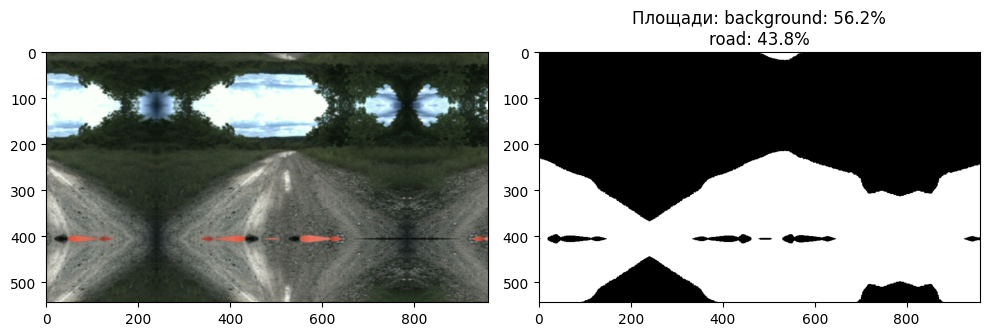

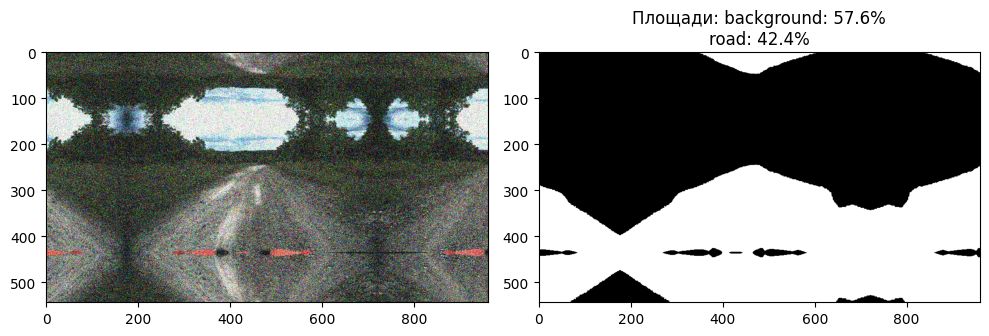

In [ ]:
augmented_dataset = Dataset(
    X_TRAIN_DIR, 
    Y_TRAIN_DIR, 
    augmentation=get_training_augmentation()
)

# same image with different random transforms
indx = np.random.randint(len(augmented_dataset))

# the range here gives the number of examples to show
for i in range(2):
    image, mask = augmented_dataset[indx]
    visualize_multichannel_mask(image, mask)

C:\Users\QuanumWarrior\AppData\Local\Temp\ipykernel_12496\3191627627.py:31: UserWarning: Argument(s) 'always_apply' are not valid for transform MaxSizeTransform
  test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
C:\Users\QuanumWarrior\AppData\Local\Temp\ipykernel_12496\3191627627.py:32: UserWarning: Argument(s) 'always_apply' are not valid for transform PadIfNeeded
  albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=2, always_apply=True),
C:\Users\QuanumWarrior\AppData\Local\Temp\ipykernel_12496\3191627627.py:33: UserWarning: Argument(s) 'always_apply' are not valid for transform CenterCrop
  albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]


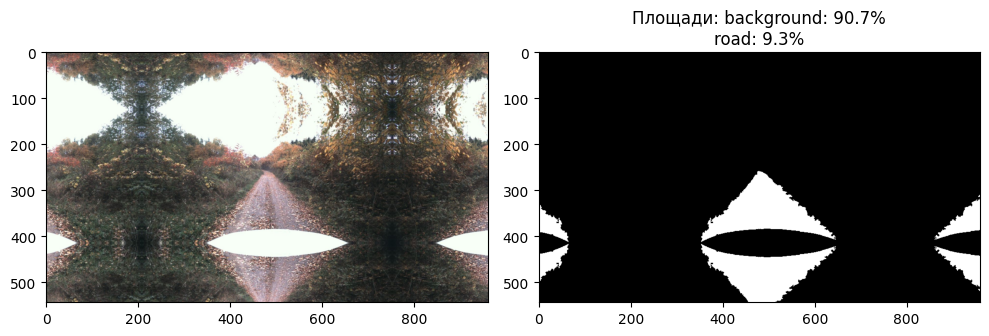

In [10]:
augmented_dataset = Dataset(
    X_VALID_DIR, 
    Y_VALID_DIR, 
    augmentation=get_validation_augmentation()
)

indx = np.random.randint(len(augmented_dataset))

image, mask = augmented_dataset[indx]
visualize_multichannel_mask(image, mask)

# Model

In [ ]:
class model_runner:
    def __init__(self, arch=MODEL_NAME, en=ENCODER, en_w=ENCODER_WEIGHTS, cl=len(CLASSES), ac=ACTIVATION, 
                 xtd = X_TRAIN_DIR, ytd = Y_TRAIN_DIR, xvd = X_VALID_DIR, yvd = Y_VALID_DIR,
                 ilr = INIT_LR, loss = loss, bs_train=16, bs_val = 1):
        self.model = smp.create_model(
            arch=arch
            encoder_name=en, 
            encoder_weights=en_w, 
            classes=cl, 
            activation=ac,
        )
        self.preprocessing_fn = smp.encoders.get_preprocessing_fn(en, en_w)
        self.train_dataset = Dataset(
            xtd, 
            ytd, 
            augmentation=get_training_augmentation(), 
            preprocessing=get_preprocessing(self.preprocessing_fn)
        )

        self.valid_dataset = Dataset(
            xvd, 
            yvd, 
            augmentation=get_validation_augmentation(), 
            preprocessing=get_preprocessing(self.preprocessing_fn)
        )

        self.train_loader = DataLoader(self.train_dataset, batch_size=bs_train, shuffle=True)
        self.valid_loader = DataLoader(self.valid_dataset, batch_size=bs_val, shuffle=False)

        self.metrics = [
            utils.metrics.Fscore(),
            utils.metrics.IoU()
        ]

        self.optimizer = torch.optim.Adam([ 
            dict(params=self.model.parameters(), lr=ilr),
        ])

        # create epoch runners 
        # it is a simple loop of iterating over dataloader`s samples
        self.train_epoch = utils.train.TrainEpoch(
            self.model, 
            loss=loss, 
            metrics=self.metrics, 
            optimizer=self.optimizer,
            device=DEVICE,
            verbose=True,
        )

        self.valid_epoch = utils.train.ValidEpoch(
            self.model, 
            loss=loss, 
            metrics=self.metrics, 
            device=DEVICE,
            verbose=True,
        )

    def run_model(self, model_save_name = MODEL_SAVE_NAME, model_save_dir = MODEL_SAVE_DIR, epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, lr_decrease_step=LR_DECREASE_STEP, lr_decrease_coef=LR_DECREASE_COEF):
        max_score = 0
        loss_logs = {"train": [], "val": []}
        metric_logs = {"train": [], "val": []}

        for i in range(0, epochs):
    
            print('\nEpoch: {}'.format(i))
            train_logs = self.train_epoch.run(self.train_loader)
            train_loss, train_metric, train_metric_IOU = list(train_logs.values())
            loss_logs["train"].append(train_loss)
            metric_logs["train"].append(train_metric_IOU)

            valid_logs = self.valid_epoch.run(self.valid_loader)
            val_loss, val_metric, val_metric_IOU = list(valid_logs.values())
            loss_logs["val"].append(val_loss)
            metric_logs["val"].append(val_metric_IOU)
    
            # do something (save model, change lr, etc.)
            if max_score < valid_logs['iou_score']:
                max_score = valid_logs['iou_score']
                torch.save(self.model, f'{model_save_dir}/{model_save_name}.pth')
                # Save the model with JIT
                # Create a tensor with the specified dimensions
                trace_image = torch.randn(batch_size, 3, INFER_HEIGHT, INFER_WIDTH)
                # Trace the model using the example input
                traced_model = torch.jit.trace(self.model, trace_image.to(DEVICE))
                torch.jit.save(traced_model, f'{model_save_dir}/{model_save_name}.pt')
                print('Model saved!')

            print("LR:", self.optimizer.param_groups[0]['lr'])
            if i > 0 and i % lr_decrease_step == 0:
                print('Decrease decoder learning rate')
                self.optimizer.param_groups[0]['lr'] /= lr_decrease_coef

        self.loss_logs = loss_logs
        self.metric_logs = metric_logs
            
    def plot_model(self):
        fig, axes = plt.subplots(1, 2, figsize=(10,4))
        axes[0].plot(self.loss_logs["train"], label = "train")
        axes[0].plot(self.loss_logs["val"], label = "val")
        axes[0].set_title("losses - Dice")

        axes[1].plot(self.metric_logs["train"], label = "train")
        axes[1].plot(self.metric_logs["val"], label = "val")
        axes[1].set_title("IOU")

        [ax.legend() for ax in axes];

In [ ]:
# This can now be copied many times
model_name = MODEL_NAME
encoder = ENCODER
save_file = MODEL_SAVE_NAME

model1 = smp.create_model(
    arch=model_name,
    en=encoder, 
)

model1.run_model(model_save_name = save_file)
model1.plot_model()

# Model Evaluation

In [ ]:
# Definitions

def get_validation_augmentation():
    test_transform = [albu.LongestMaxSize(max_size=INFER_HEIGHT, always_apply=True),
    albu.PadIfNeeded(min_height=INFER_HEIGHT, min_width=INFER_WIDTH, border_mode=0, always_apply=True),
    albu.CenterCrop(height=INFER_HEIGHT, width=INFER_WIDTH, always_apply=True)]
    return albu.Compose(test_transform)

In [ ]:
colors_imshow = {
        "background" : np.array([0, 0, 0]),
        "road" : np.array([255, 255, 255]),
    }


def _colorize_mask(mask: np.ndarray):
    mask = mask.squeeze()
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    square_ratios = {}
    for cls_code, cls in enumerate(CLASSES):
        cls_mask = mask == cls_code
        square_ratios[cls] = cls_mask.sum() / cls_mask.size
        colored_mask += np.multiply.outer(cls_mask, colors_imshow[cls]).astype(np.uint8)

    return colored_mask, square_ratios


def reverse_normalize(img, mean, std):
    # Invert normalization
    img = img * np.array(std) + np.array(mean)
    return img


def visualize_predicts(img: np.ndarray, mask_gt: np.ndarray, mask_pred: np.ndarray, normalized=False):
    # размер img: H, W, CHANNEL
    # размер mask_gt, mask_pred: H, W, значения - range(len(CLASSES)
    _, axes = plt.subplots(1, 3, figsize=(10, 5))
    img = img.transpose(1, 2, 0)
    if normalized:
        # Reverse the normalization to get the unnormalized image
        img = reverse_normalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    axes[0].imshow(img)

    mask_gt, square_ratios = _colorize_mask(mask_gt)
    title = "Площади:\n" + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    axes[1].imshow(mask_gt, cmap="twilight")
    axes[1].set_title(f"GT маска\n" + title)

    mask_pred, square_ratios = _colorize_mask(mask_pred)
    title = "Площади:\n" + "\n".join([f"{cls}: {square_ratios[cls]*100:.1f}%" for cls in CLASSES])
    axes[2].imshow(mask_pred, cmap="twilight")
    axes[2].set_title(f"PRED маска\n" + title)

    plt.tight_layout()
    plt.show()

In [ ]:
class model_test:
    def __init__(self, filename, encoder, encoder_weights = ENCODER_WEIGHTS, xtd = X_TEST_DIR, ytd = Y_TEST_DIR, loss=loss):
        #self.best_model = torch.load(f'{filename}.pth')
        self.best_model = torch.jit.load(f'{filename}.pt', map_location=DEVICE)

        self.preprocessing_fn = smp.encoders.get_preprocessing_fn(encoder, encoder_weights)

        self.metrics = [
            utils.metrics.Fscore(),
            utils.metrics.IoU()
        ]

        # оценка IoU
        self.test_dataset = Dataset(
            xtd, 
            ytd, 
            augmentation=get_validation_augmentation(), 
            preprocessing=get_preprocessing(self.preprocessing_fn)
        )

        self.test_dataloader = DataLoader(self.test_dataset)

        self.test_epoch = smp.utils.train.ValidEpoch(
            model=self.best_model,
            loss=loss,
            metrics=self.metrics,
            device=DEVICE,
        )

    def run_test(self):
        logs = self.test_epoch.run(self.test_dataloader)
        return logs
    
    def show_rnd_plots(self, num_plots=2):
        
        for i in range(num_plots):
            n = np.random.choice(len(self.test_dataset))
    
            image, gt_mask = self.test_dataset[n]
            gt_mask = gt_mask.squeeze()
    
            x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
            pr_mask = self.best_model(x_tensor)
            pr_mask = pr_mask.squeeze().cpu().detach().numpy()
    
            label_mask = np.argmax(pr_mask, axis=0)
            print(label_mask.shape, image.shape, gt_mask.shape)

            visualize_predicts(image, np.argmax(gt_mask, axis=0), label_mask, normalized=True)

In [ ]:
# load best saved checkpoint
# load this for all, to check

model_save_dir = MODEL_SAVE_DIR
model_save_name = MODEL_SAVE_NAME
encoder = ENCODER

filename = f'{model_save_dir}/{model_save_name}'
best_m = model_test(filename, encoder)

logs = best_m.run_test()
best_m.show_rnd_plots(2)